In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
import pickle

import shap
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge


In [2]:
X_train = pd.read_csv("../data/input/X_train.csv")
X_test = pd.read_csv("../data/input/X_test.csv")
y_train = pd.read_csv("../data/input/y_train.csv")
y_test =pd.read_csv("../data/input/y_test.csv")

In [3]:
print(X_test.shape)
print(X_train.shape)

(3691, 90)
(8611, 90)


In [4]:
def evaluate_and_plot(model, X_train, y_train, X_test, y_test, model_name):
    # Predict the values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Inverse the log-transformation to get the original scale
    y_test_pred = np.expm1(y_test_pred)
    y_train_pred = np.expm1(y_train_pred)
    y_test = np.expm1(y_test)
    y_train = np.expm1(y_train)

    # Calculate RMSE and R^2 scores
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the performance metrics
    print(f"{model_name}:")
    print(f"  Training RMSE: {train_rmse:.2f}, R^2: {train_r2:.2f}")
    print(f"  Test RMSE: {test_rmse:.2f}, R^2: {test_r2:.2f}")

    # Plot predicted vs actual values with light yellow points and no border
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='#6753BF', label='Predicted vs Actual')  # light yellow color
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Ideal Fit (y = x)')
    
    # Add labels and title with custom styling
    plt.xlabel('Actual Values', fontsize=14, weight='bold')
    plt.ylabel('Predicted Values', fontsize=14, weight='bold')
    plt.title(f'Actual vs Predicted Values for {model_name}', fontsize=16, weight='bold', color='navy')

    # Customize ticks and add grid for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # Adding a legend with custom styling
    plt.legend(fontsize=12, loc='upper left')
    
    # Display the plot
    plt.tight_layout()
    plt.show()


In [5]:
models = [
    (DecisionTreeRegressor(), "Decision Tree Regressor"),
    (ExtraTreesRegressor(), "Extra Trees Regressor"),
    (RandomForestRegressor(), "Random Forest Regressor"),
    (AdaBoostRegressor(), "AdaBoost Regressor"),
    (GradientBoostingRegressor(), "Gradient Boosting Regressor"),
    (XGBRegressor(objective='reg:squarederror', n_estimators=120, learning_rate=0.15, max_depth=5, random_state=42), "XGBoost Regressor"),
    (Lasso(alpha=0.00001), "Lasso Regression"),
    (Ridge(alpha=0.7), "Ridge Regression")
]

In [6]:
lasso_model = Lasso(alpha = 0.00001)
lasso_model = lasso_model.fit(X_train, y_train)
y_pred_train = lasso_model.predict(X_train)
y_pred_test = lasso_model.predict(X_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# algo = str(algorithm).split("'")[1].split(".")[-1]
accuracy_metrics = {'R2_train' : r2_train,
                    'R2_test'  : r2_test}
accuracy_metrics

{'R2_train': 0.624219349751308, 'R2_test': 0.6126779411637715}

Decision Tree Regressor:
  Training RMSE: 0.08, R^2: 1.00
  Test RMSE: 111.37, R^2: 0.42


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


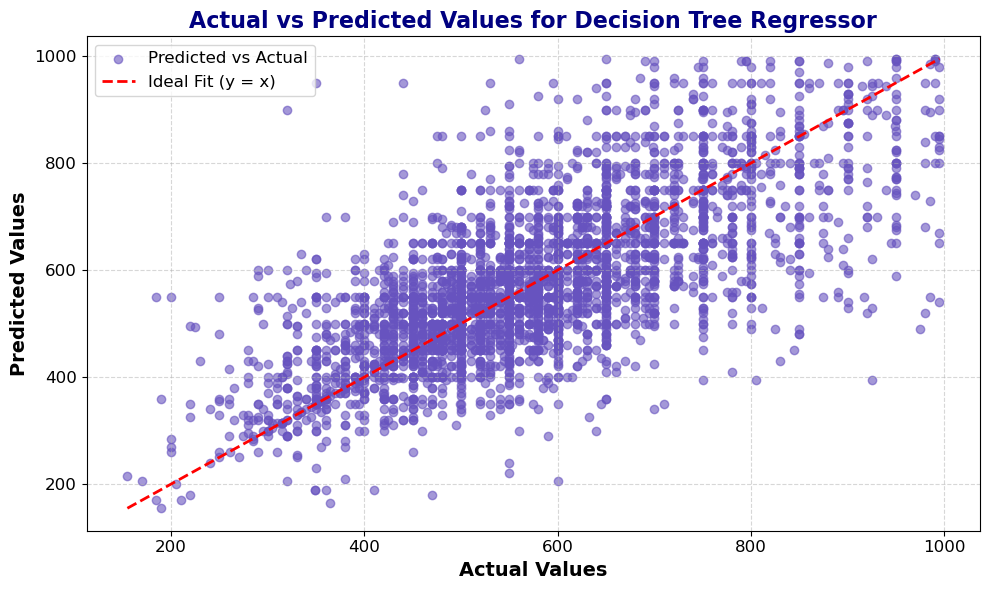

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Extra Trees Regressor:
  Training RMSE: 0.08, R^2: 1.00
  Test RMSE: 76.74, R^2: 0.72


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


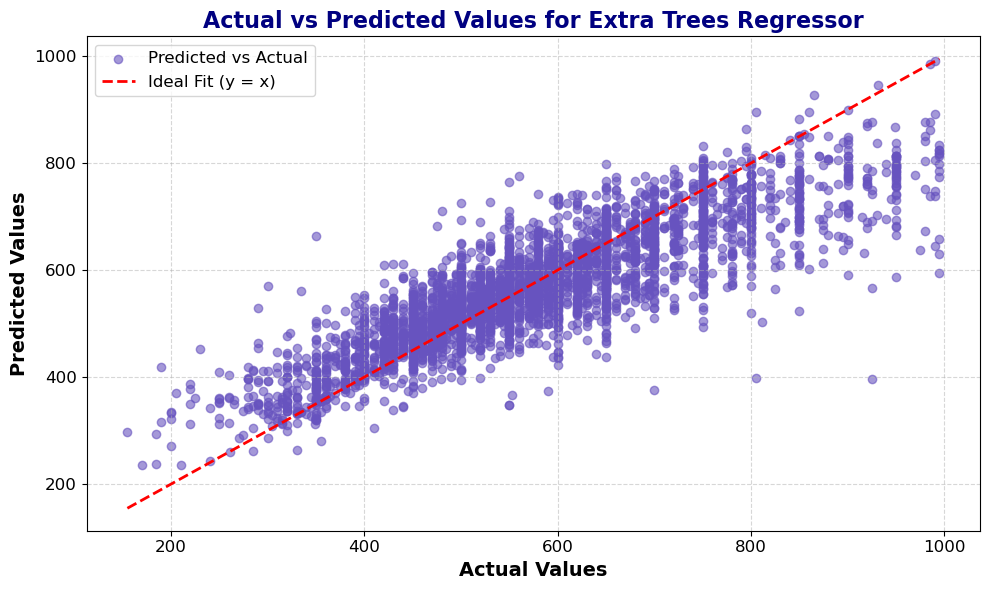

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Regressor:
  Training RMSE: 29.67, R^2: 0.96
  Test RMSE: 78.53, R^2: 0.71


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


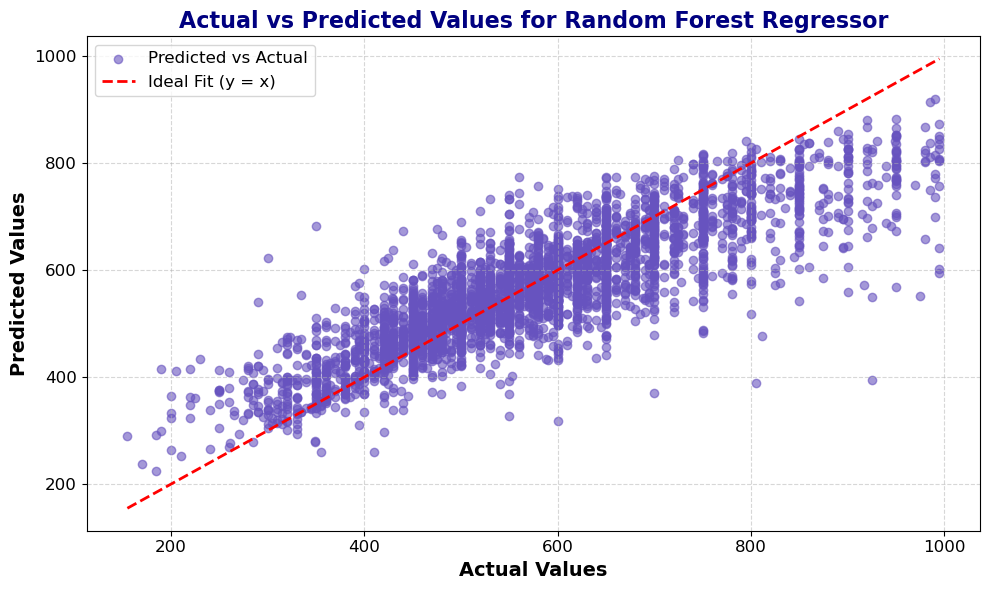

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost Regressor:
  Training RMSE: 103.13, R^2: 0.50
  Test RMSE: 106.93, R^2: 0.46


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


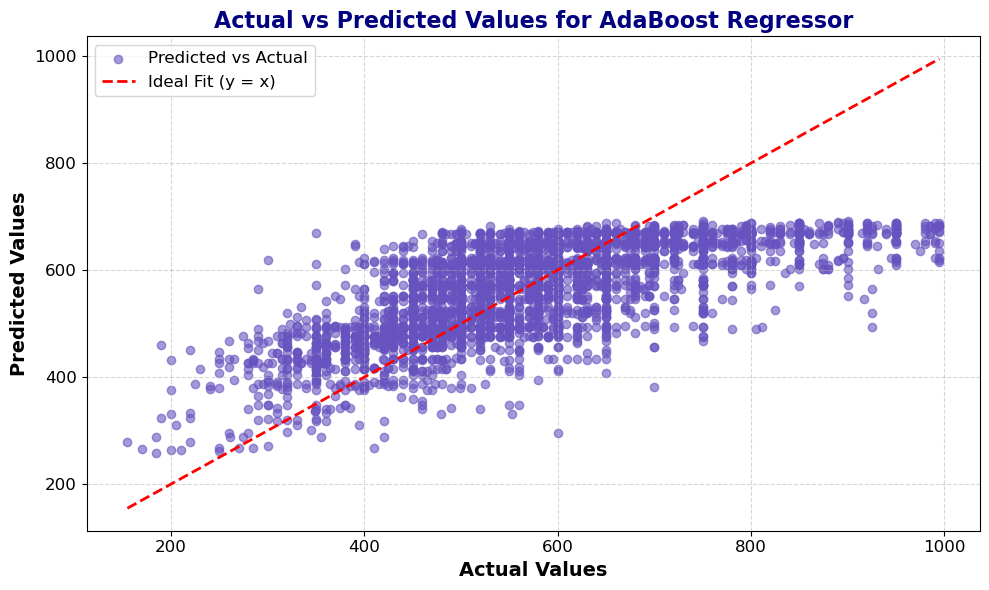

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Gradient Boosting Regressor:
  Training RMSE: 70.31, R^2: 0.77
  Test RMSE: 79.43, R^2: 0.70


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


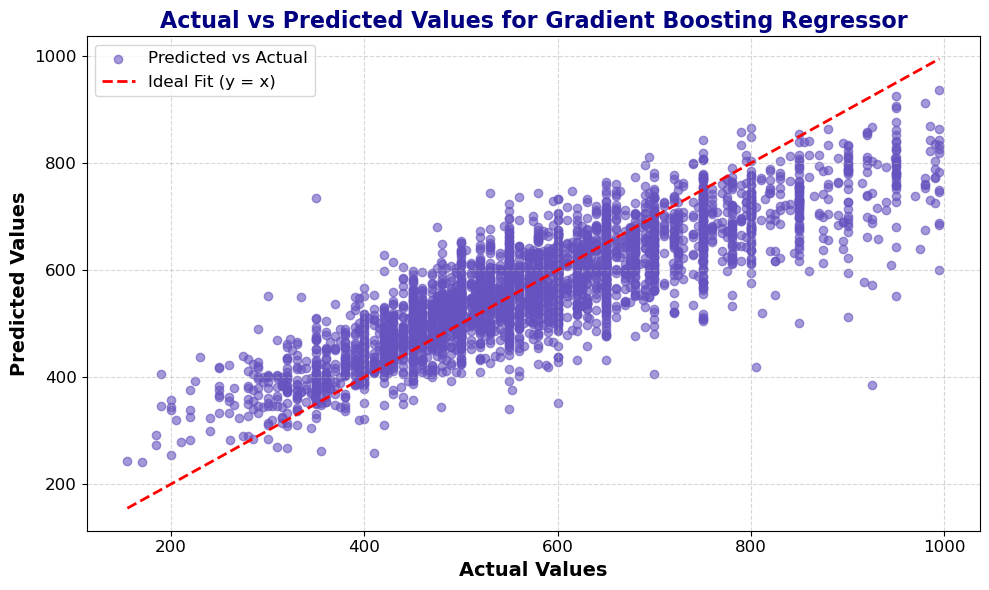

XGBoost Regressor:
  Training RMSE: 36.54, R^2: 0.94
  Test RMSE: 64.52, R^2: 0.80


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


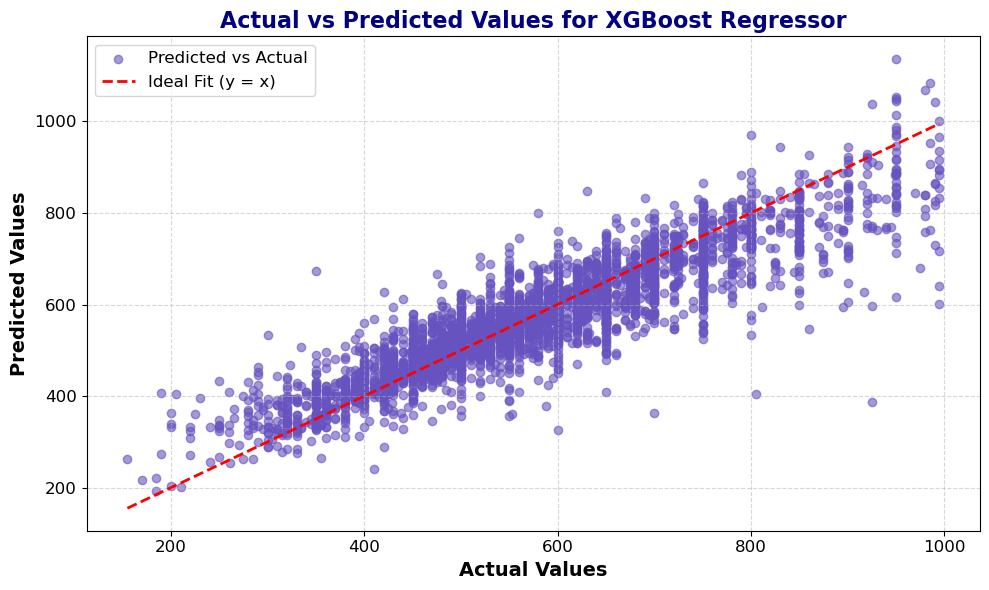

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Lasso Regression:
  Training RMSE: 96.69, R^2: 0.56
  Test RMSE: 92.96, R^2: 0.59


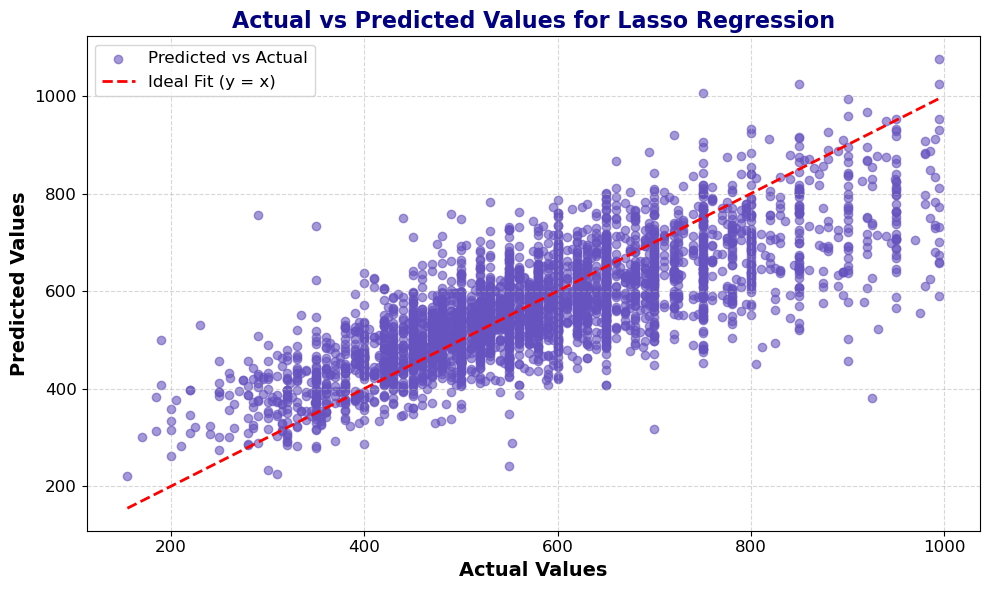

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge Regression:
  Training RMSE: 96.67, R^2: 0.56
  Test RMSE: 92.96, R^2: 0.59


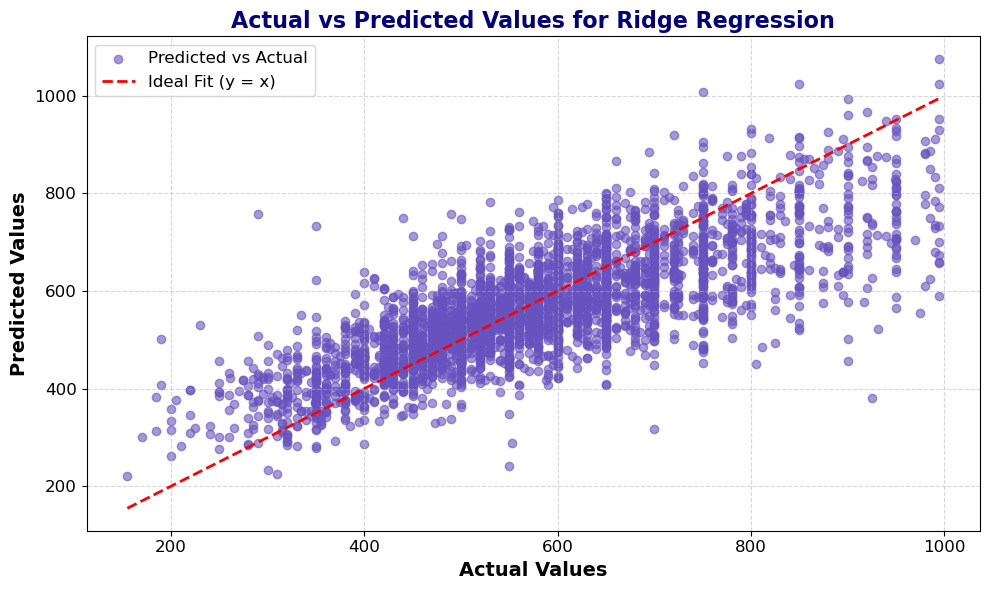

In [7]:
for model, name in models:
    model.fit(X_train, y_train)
    evaluate_and_plot(model, X_train, y_train, X_test, y_test, name)


In [8]:
base_learners = [
    ('rf', ExtraTreesRegressor()),
    ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.01)),
    ('gbr', XGBRegressor(objective='reg:squarederror', 
    n_estimators=120,             
    learning_rate=0.15,           
    max_depth=5,                  
    random_state=42  )),
    # ('lasso', Lasso(alpha = 0.00001))
]

meta_learner = LinearRegression()
stack_regressor = StackingRegressor(estimators=base_learners, final_estimator=meta_learner)

stack_regressor.fit(X_train, y_train)

/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/ensemble/_stacking.py:970: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


StackingRegressor(estimators=[('rf', ExtraTreesRegressor()),
                              ('svr', SVR(epsilon=0.01)),
                              ('gbr',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            import...None,
                                            interaction_constraints=None,
                                            learning_rate=0.15, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=120, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=LinearRegression())

Stacking Regressor:
  Training RMSE: 32.03, R^2: 0.95
  Test RMSE: 50.08, R^2: 0.88


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


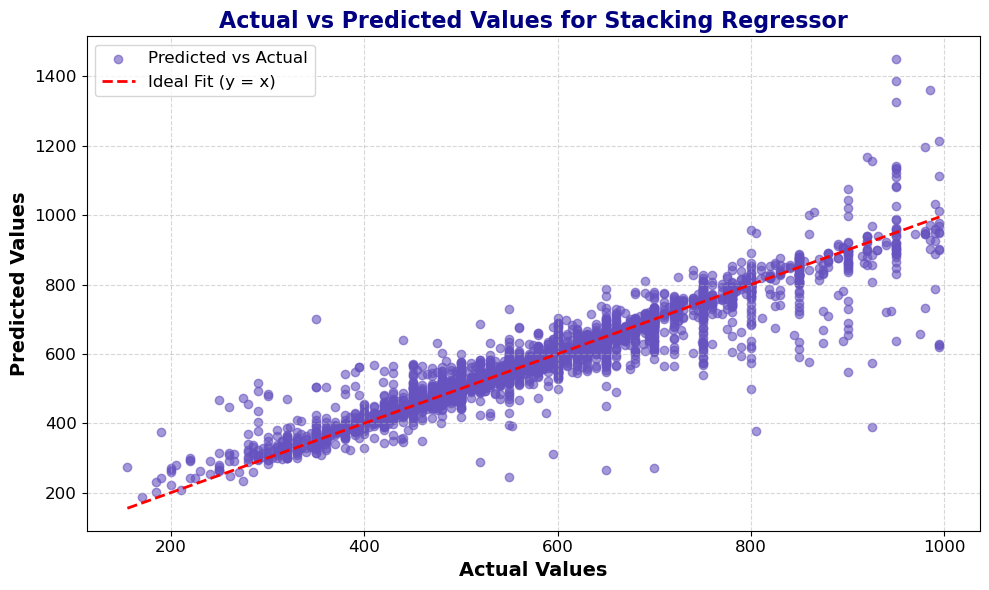

In [9]:
evaluate_and_plot(stack_regressor, X_train, y_train, X_test, y_test, "Stacking Regressor")

## DNN


In [10]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 256)
        self.layer4 = nn.Linear(256, 256)
        self.output_layer = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.output_layer(x)
        return x

input_dim = X_train.shape[1]
model = NeuralNetwork(input_dim)
print(model)

criterion = nn.L1Loss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



NeuralNetwork(
  (layer1): Linear(in_features=90, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=256, bias=True)
  (layer3): Linear(in_features=256, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=256, bias=True)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)


In [11]:
num_epochs = 50 

best_loss = float('inf')
patience, trials = 10, 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


    model.eval()
    with torch.no_grad():
        val_loss = criterion(model(X_test_tensor), y_test_tensor).item()
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')  
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(torch.load('best_model.pt')) 
            break


Epoch 1/50, Loss: 0.6632
Epoch 2/50, Loss: 0.1845
Epoch 3/50, Loss: 0.1321
Epoch 4/50, Loss: 0.1171
Epoch 5/50, Loss: 0.1198
Epoch 6/50, Loss: 0.1025
Epoch 7/50, Loss: 0.0982
Epoch 8/50, Loss: 0.0887
Epoch 9/50, Loss: 0.0751
Epoch 10/50, Loss: 0.0880
Epoch 11/50, Loss: 0.0783
Epoch 12/50, Loss: 0.0756
Epoch 13/50, Loss: 0.0728
Epoch 14/50, Loss: 0.0661
Epoch 15/50, Loss: 0.0799
Epoch 16/50, Loss: 0.0639
Epoch 17/50, Loss: 0.0570
Epoch 18/50, Loss: 0.0606
Epoch 19/50, Loss: 0.0597
Epoch 20/50, Loss: 0.0556
Epoch 21/50, Loss: 0.0565
Epoch 22/50, Loss: 0.0570
Epoch 23/50, Loss: 0.0588
Epoch 24/50, Loss: 0.0635
Epoch 25/50, Loss: 0.0624
Epoch 26/50, Loss: 0.0532
Epoch 27/50, Loss: 0.0477
Epoch 28/50, Loss: 0.0543
Epoch 29/50, Loss: 0.0454
Epoch 30/50, Loss: 0.0463
Epoch 31/50, Loss: 0.0485
Epoch 32/50, Loss: 0.0554
Epoch 33/50, Loss: 0.0550
Epoch 34/50, Loss: 0.0470
Epoch 35/50, Loss: 0.0500
Epoch 36/50, Loss: 0.0463
Epoch 37/50, Loss: 0.0435
Epoch 38/50, Loss: 0.0385
Epoch 39/50, Loss: 0.

In [12]:
model.eval()  
with torch.no_grad():  
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    print(f"Test Loss: {test_loss.item():.4f}")


Test Loss: 0.0407


In [13]:
y_pred_test_numpy = y_pred_test.numpy()  
y_pred_test_original_scale = np.expm1(y_pred_test_numpy)

y_test_numpy = y_test_tensor.numpy()
y_test_original_scale = np.expm1(y_test_numpy)

for actual, predicted in zip(y_pred_test_original_scale[:10], y_test_original_scale[:10]):
    print(f"Actual: {actual}, Predicted: {predicted}")


Actual: [533.98694], Predicted: [549.99994]
Actual: [521.759], Predicted: [540.00006]
Actual: [587.9474], Predicted: [599.99994]
Actual: [182.35696], Predicted: [900.0001]
Actual: [459.2025], Predicted: [460.]
Actual: [646.7161], Predicted: [660.00006]
Actual: [626.2216], Predicted: [845.0001]
Actual: [481.76578], Predicted: [500.00003]
Actual: [652.84296], Predicted: [649.9999]
Actual: [530.97046], Predicted: [514.99994]


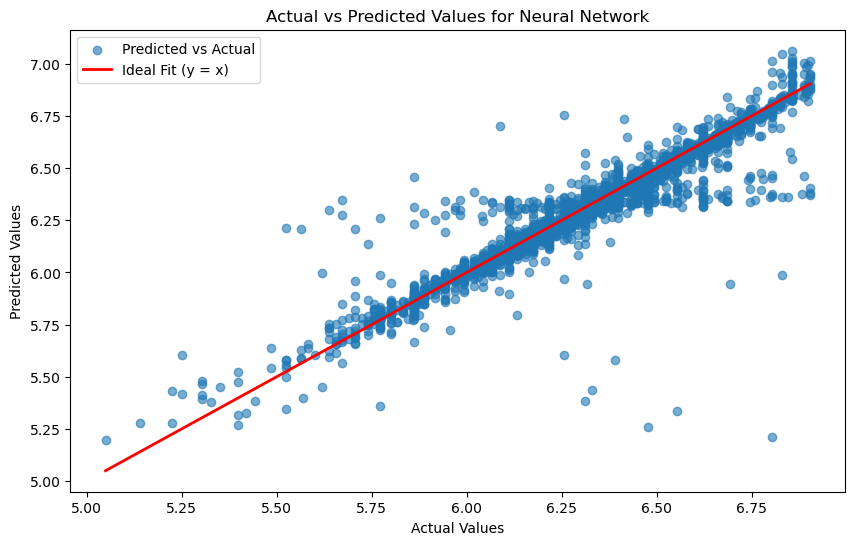

In [14]:
y_pred_test_numpy = y_pred_test.numpy()
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_numpy, alpha=0.6, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='-', linewidth=2, label='Ideal Fit (y = x)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Neural Network')
plt.legend()
plt.show()

In [15]:
rmse = mean_squared_error(y_test_original_scale, y_pred_test_original_scale, squared=False)
r2 = r2_score(y_test_original_scale, y_pred_test_original_scale)
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

RMSE: 49.1215
R^2: 0.8865


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Tab Transformer

In [16]:
class TabTransformer(nn.Module):
    def __init__(self, input_dim, n_heads=8, n_layers=2, dropout=0.1):
        super(TabTransformer, self).__init__()
        self.input_layer = nn.Linear(input_dim, 128)
        
        encoder_layers = nn.TransformerEncoderLayer(d_model=128, nhead=n_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=n_layers)
        
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        x = self.input_layer(x)
        # (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)
        # Aggregate over sequence length dimension (if seq_len > 1)
        x = x.mean(dim=1)
        x = self.output_layer(x)
        return x

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

input_dim = X_train.shape[1]
model = TabTransformer(input_dim)
print(model)

#loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

# Training params
num_epochs = 50
best_loss = float('inf')
patience, trials = 10, 0

# learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    with torch.no_grad():
        val_pred = model(X_test_tensor)
        val_loss = criterion(val_pred, y_test_tensor).item()
    print(f"Validation Loss: {val_loss:.4f}")

    # Scheduler step
    scheduler.step(val_loss)

    # Early stopping (avoid overfitting)
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        trials = 0
    else:
        trials += 1
        if trials >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(torch.load('best_model.pt'))
            break

# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
with torch.no_grad():
    final_predictions = model(X_test_tensor)

TabTransformer(
  (input_layer): Linear(in_features=90, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)


Epoch 1/50, Loss: 0.1769
Validation Loss: 0.1902
Epoch 2/50, Loss: 0.0927
Validation Loss: 0.0924
Epoch 3/50, Loss: 0.0821
Validation Loss: 0.0881
Epoch 4/50, Loss: 0.0757
Validation Loss: 0.1257
Epoch 5/50, Loss: 0.0701
Validation Loss: 0.1694
Epoch 6/50, Loss: 0.0672
Validation Loss: 0.0819
Epoch 7/50, Loss: 0.0643
Validation Loss: 0.1389
Epoch 8/50, Loss: 0.0612
Validation Loss: 0.1513
Epoch 9/50, Loss: 0.0598
Validation Loss: 0.1575
Epoch 10/50, Loss: 0.0615
Validation Loss: 0.1135
Epoch 00010: reducing learning rate of group 0 to 1.0000e-04.
Epoch 11/50, Loss: 0.0468
Validation Loss: 0.1154
Epoch 12/50, Loss: 0.0428
Validation Loss: 0.1038
Epoch 13/50, Loss: 0.0417
Validation Loss: 0.1037
Epoch 14/50, Loss: 0.0411
Validation Loss: 0.0948
Epoch 00014: reducing learning rate of group 0 to 1.0000e-05.
Epoch 15/50, Loss: 0.0401
Validation Loss: 0.1058
Epoch 16/50, Loss: 0.0394
Validation Loss: 0.1056
Early stopping at epoch 16


In [17]:
final_predictions_inv  = np.expm1(final_predictions)
rmse = mean_squared_error(y_test_original_scale, final_predictions_inv, squared=False)
r2 = r2_score(y_test_original_scale, final_predictions_inv)
print(f"RMSE: {rmse:.4f}")
print(f"R^2: {r2:.4f}")

RMSE: 65.3987
R^2: 0.7989


/Users/tinas/anaconda3/envs/group25env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## SHAP

 97%|=================== | 8392/8611 [00:26<00:00]       

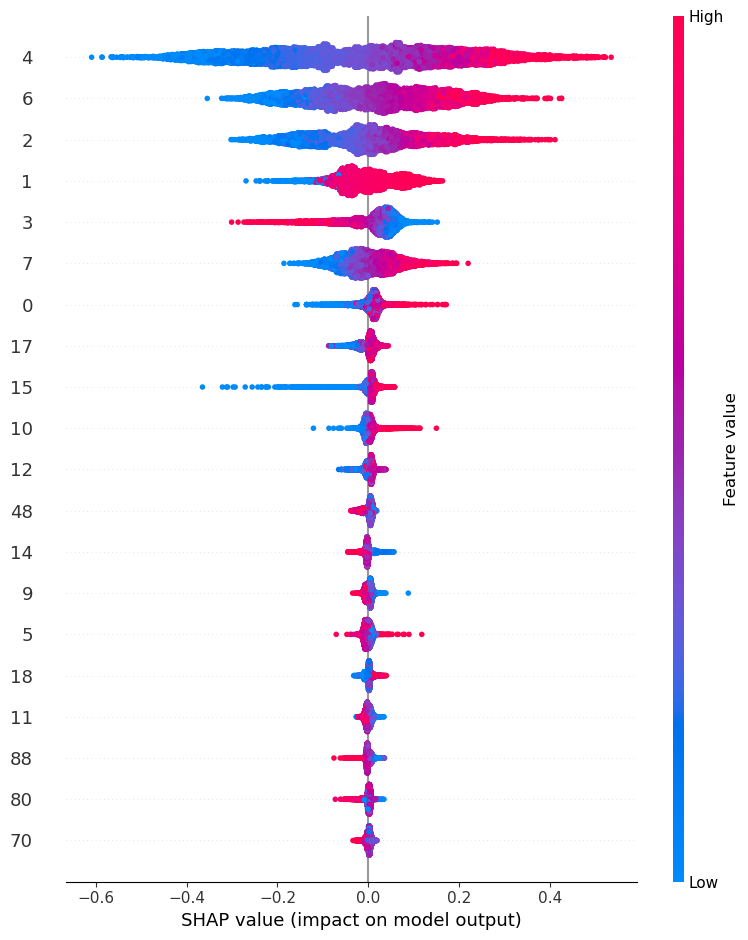

In [18]:
explainer = shap.Explainer(XGBRegressor().fit(X_train, y_train), X_train)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)